# DSCI 100 Project Group 1 
**By: Tima Komarov (82239450), Carmen Wen (95556593), Pim-on Ingkanisorn(44803013), Omar Harb (57845414)**
<br>

# Introduction
The UBC Computer Science research group, led by Frank Wood, set up a MineCraft server to collect in-game data on player behaviours. The recorded data will be used in this project to explore factors that influence players' engagement, specifically focusing on which characteristics and behaviours predict a player's likelihood of subscribing to the game's newsletter. 

For this project, we aim to answer the broad question: "What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?" More specifically, **can the number of hours played and the players age predict if a player subscribes to a game related newsletter in the players data set?** 

We would do this by using the players.csv dataset, which contains about 7 variables. However, for our analysis, only played_hours, and Age will be utilized to develop a predictive model using k-nearest neighbours for subscription likelihood.

| Variable Name  | Type        | Description |
|---------------|------------|-------------|
| played_hours| Numeric     | Total hours played |
| Age         | Numeric     | Player’s age (8 to 50 years) |
| subscribe   | logical     | subscription status (TRUE/FALSE) |
<p style="text-align: center; font-style:italic">Figure 1 - Variables used in the data analysis</p>

We expect that a player's played_hours and Age be used as predictors of their subscription status.


# Methods

**Describe what we will do (data wrangling)**

In this dataset, the subscription status must be converted to a factor variable during wrangling, while Age and played hours stay as numeric variables. Then we must ensure that all NA values are removed before creating a KNN classification model.

- why 80-20 train-test

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("https://raw.githubusercontent.com/crmnwn06/minecraft-data/refs/heads/main/players.csv" )

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
clean_player <- players |> 
    select(subscribe, played_hours,Age) |>
    mutate(subscribe=as_factor(subscribe)) |>
    na.omit()
head(clean_player)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


*Figure 2 - Clean dataset with the `subscribe`, `played_hours`, and `Age` variables*

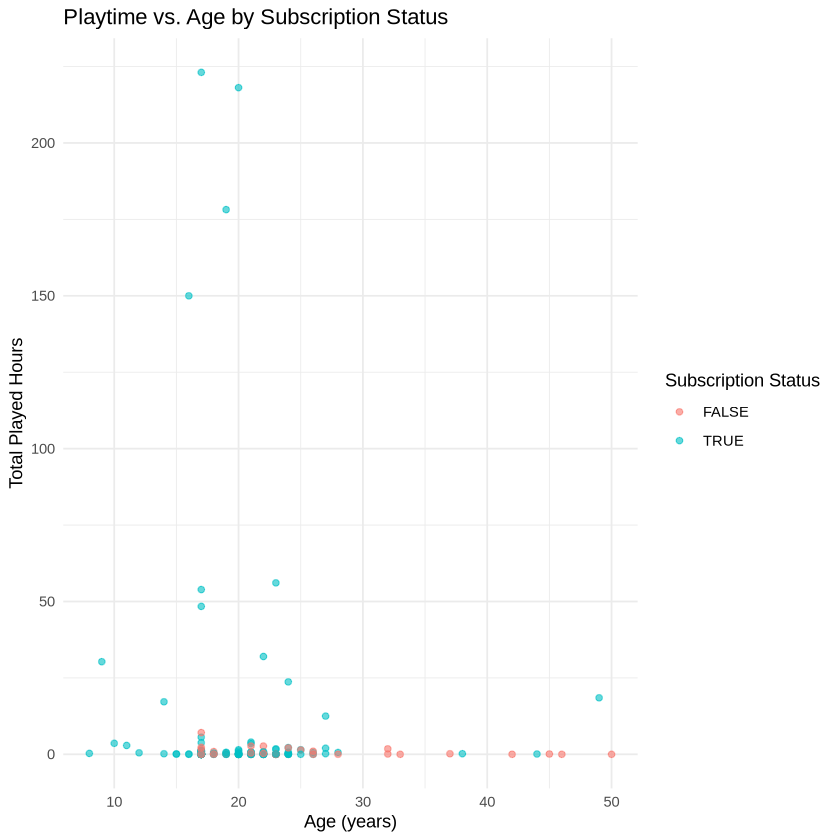

In [4]:
#Visualization of data: Scatter Plot of Playtime vs. Age (Colored by Subscription Status)
ggplot(clean_player, aes(x = Age, y = played_hours, color = as.factor(subscribe))) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Playtime vs. Age by Subscription Status",
    x = "Age (years)",
    y = "Total Played Hours",
    color = "Subscription Status"
  ) +
  theme_minimal()

*Figure 3 - Scatter Plot of Playtime vs. Age (Coloured by Subscription Status)*

The above scatter plot reveals a that many players in their early twenties have the most played hours.

Before classification, we must determine the balance of subscriptions status to later determine whether our algorithm is better at predicting than random guessing. 

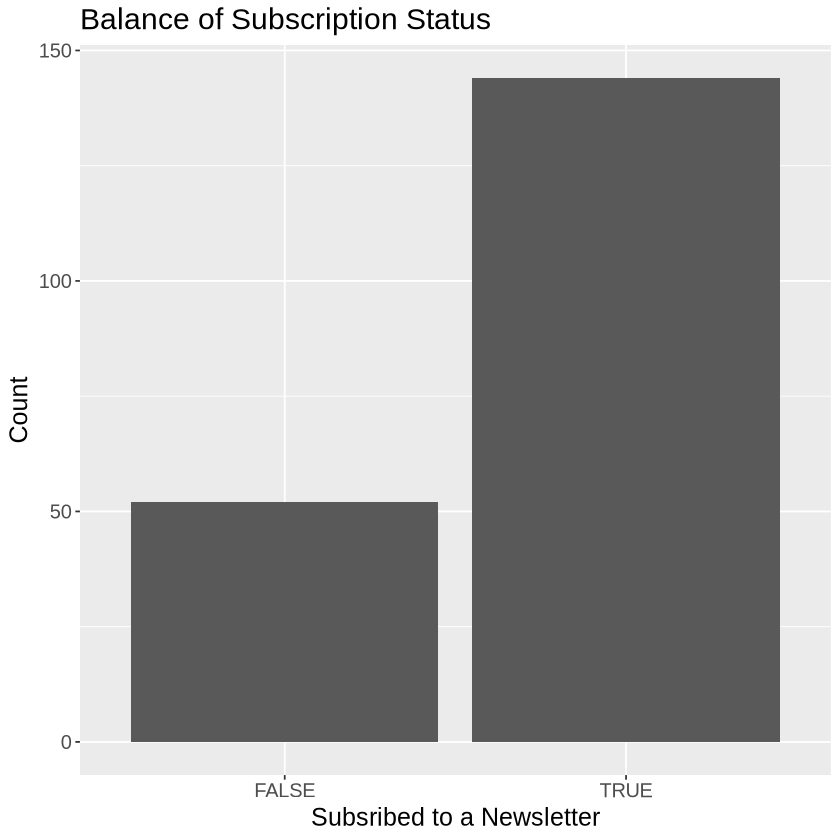

In [5]:
#balance of subscription status
ggplot(players, aes(x = subscribe)) +
    geom_bar() +
    labs(x = 'Subsribed to a Newsletter',
         y = 'Count',
         title = 'Balance of Subscription Status') +
    theme(text = element_text(size = 15))

*Figure 4 - Balance of Subsription Status*

We can tell that there is an obvious imbalance between the number of false and trues. This means that we need to calculate the random accuracy using the accuracy formula. 

In [6]:
# Given class counts
true_count <- 142
false_count <- 52
total_count <- true_count + false_count

# Calculate probabilities
p_true <- true_count / total_count
p_false <- false_count / total_count

# Random guessing accuracy formula
random_accuracy <- (p_true^2) + (p_false^2)

random_accuracy

[1] 0.6076097

Here, the data is split into the training set (`player_train`) and the testing set (`player_test`). We choose to use 80% of the initial data as the training set and 20% as the testing set, as per general practice.

In [7]:
set.seed(2025) 
player_split <- initial_split(clean_player, prop = 0.8, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

A classifcation model is specified. The recipe labels the `subscribe` variable as the response variable, and the `played_hours` and `Age` variable as the predictor variables. The intention is to find the best K-value to maximize accuracy for our final classification model.

In [ ]:
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

recipe <- recipe(subscribe ~ ., data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_fold <- vfold_cv(player_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(spec) |>
  tune_grid(resamples = player_fold, grid = k_vals) |>
  collect_metrics()

In [ ]:
#accuracies and visualizing best k value
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 10, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

*Figure 5 - Line plot of accuracy versus k to find the best k-value*

**changed k from 0 to 10** choose 7

In [10]:
#This code determines the best k value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 19

From the graph and code we can tell that 19 neighbors provides the best accuracy estimation. 

In [11]:
#resampling
resample_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")
resample_tune

recipe2 <- recipe(subscribe ~ ., data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
recipe2



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [12]:
resample_fit <- workflow() |>
  add_recipe(recipe2) |>
  add_model(resample_tune) |>
  fit(data = player_train)
resample_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2662338
Best kernel: rectangular
Best k: 19

In [13]:
#metrics 
player_predict <- predict(resample_fit, player_test) |>
  bind_cols(player_test)

player_predict |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725


*Figure 6 - Accuracy of the model*

# Results 
Using k=19, we found an accuracy of 0.725 or 72.5%.


# Conclusion
From the results, we conclude that the model correctly classifies 72.5% of the instances. Given that random guessing accuracy is ~61%, we can say that the KNN model is better at predicting a person's subscription status based on age and total played hours.

# Discussion
- found playtime and age is indicative of subscription status
- these two factors can help predict whether a player is subscribed
- limitations: only 192 observations, k is 19, so **effect?**
- future question: what is the relationship between Age, played_hours, and subscription status? Is there a positive or negative correlation between played_hours and Age?

# References